In [71]:
import pandas as pd
import numpy as np
from scipy import signal
from sklearn.cluster import KMeans
from sklearn import preprocessing
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Read the data

In [4]:
todds_file = "../data/OpenBCI-RAW-2017-08-10_15-00-02.txt"
adrians_file = "../data/OpenBCI-RAW-2017-08-10_15-06-15.txt"
zeus_file = "../data/OpenBCI-RAW-2017-08-10_15-19-42.txt"
data = {"todd":{"filename":todds_file}, "adrian":{"filename":adrians_file},"zeus":{"filename":zeus_file}}

In [12]:
def read_eeg_data(filename):
    data_cols = ["Channel_"+str(i) for i in range(16)] + ["Accel_"+str(i) for i in range(3)]
    columns = ["SampleIndex"] + data_cols + ["Timestamp"]
    df = pd.read_csv(filename,names=columns,skiprows=6)
    # drop first second and last second
    df = df.iloc[256:-256]
    df.set_index(keys='Timestamp', inplace=True)
    return df

In [13]:
for key in data:
    data[key]["data"] = read_eeg_data(data[key]["filename"])

In [14]:
data["zeus"]["data"].head()

,SampleIndex,Channel_0,Channel_1,Channel_2,Channel_3,Channel_4,Channel_5,Channel_6,Channel_7,Channel_8,Channel_9,Channel_10,Channel_11,Channel_12,Channel_13,Channel_14,Channel_15,Accel_0,Accel_1,Accel_2
Timestamp,,,,,,,,,,,,,,,,,,,,
15:20:39.084,1,-29.59,-34.33,-19.58,-27.98,-25.59,-16.34,-26.33,-17.50,-26.87,-20.32,-27.81,-24.21,-19.22,-24.88,-23.72,-20.09,0.0,0.0,0.0
15:20:39.084,2,-29.59,-34.33,-19.58,-27.98,-25.59,-16.34,-26.33,-17.50,-26.46,-20.43,-27.85,-24.27,-18.98,-24.92,-23.80,-20.30,0.0,0.0,0.0
15:20:39.089,3,-29.33,-34.35,-19.40,-28.36,-25.59,-16.27,-26.38,-17.37,-26.46,-20.43,-27.85,-24.27,-18.98,-24.92,-23.80,-20.30,0.0,0.0,0.0
15:20:39.097,4,-29.33,-34.35,-19.40,-28.36,-25.59,-16.27,-26.38,-17.37,-26.53,-20.32,-27.85,-24.18,-19.11,-24.72,-23.94,-20.47,0.0,0.0,0.0
15:20:39.097,5,-29.39,-34.53,-19.56,-28.14,-25.57,-16.23,-26.33,-17.32,-26.53,-20.32,-27.85,-24.18,-19.11,-24.72,-23.94,-20.47,0.0,0.0,0.0


In [16]:
sampling_rate = 256 #hz

In [17]:
def view_segment(df, start_index=0, stop_index=-1, sampling_rate=sampling_rate):
    duration=int(len(df.iloc[start_index:stop_index])/sampling_rate)
    print("{} seconds of recording".format(duration))
    df.iloc[start_index:stop_index][["Channel_"+str(i) for i in range(16)]].plot(figsize=(16,9))
    plt.legend(loc=6)
    plt.xlabel('Timestamp',fontsize=22)
    plt.ylabel('Relative microvolts (uV)',fontsize=22)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=22)
    plt.show()

In [43]:
halfway = int(len(data["adrian"]["data"]) / 2)

106 seconds of recording


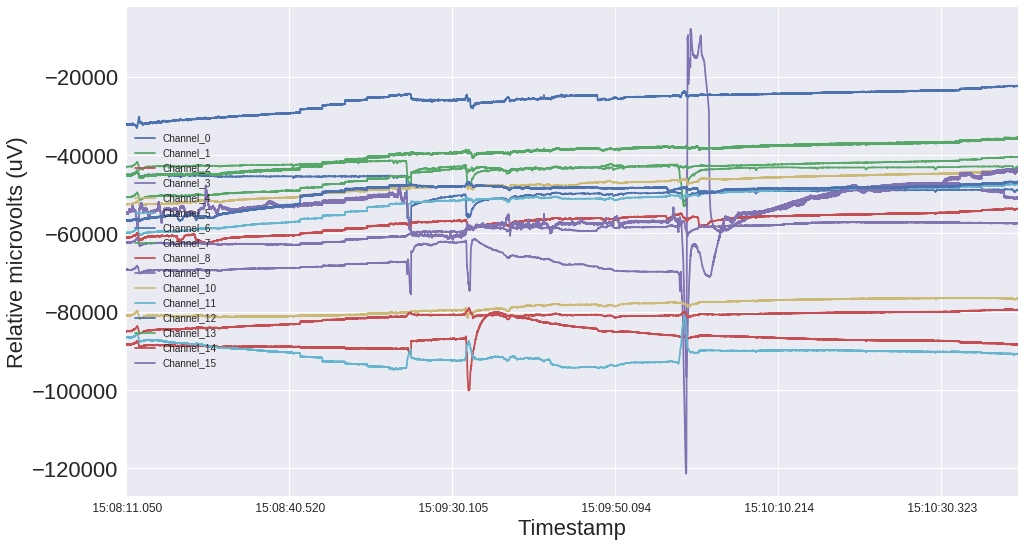

In [44]:
view_segment(data["adrian"]["data"], start_index=10000, stop_index=-3000)

In [45]:
def envelope_plot(df,start_index=1000, duration=256):
    f, axarr = plt.subplots(16, sharex=True)
    for i in range(16):
        df.iloc[start_index:start_index+sampling_rate][["Channel_" + str(i)]].plot(ax=axarr[i],figsize=(16,9))
    plt.show()

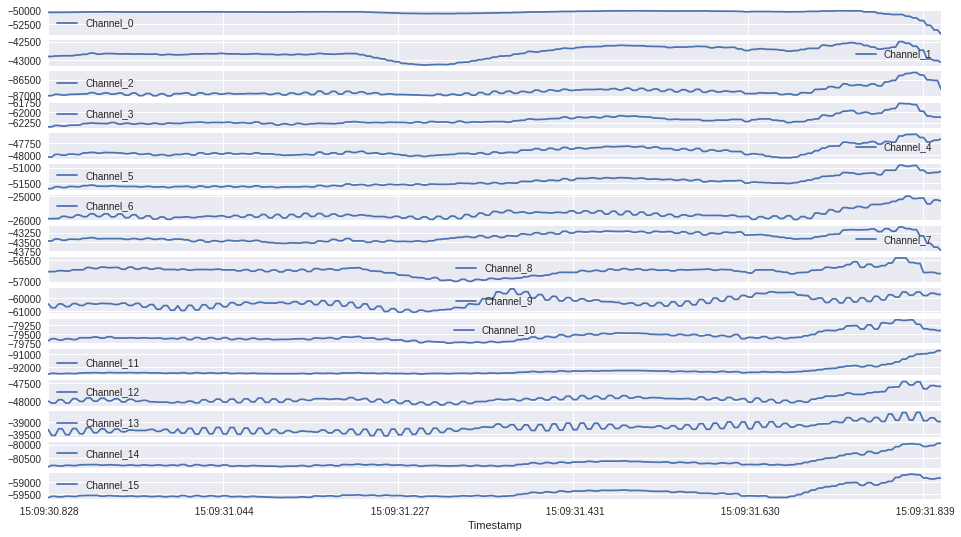

In [46]:
envelope_plot(data["adrian"]["data"],start_index=halfway)

In [68]:
def bandpass_filter(df, channel=8, highpass_freqs=[1.],notch_freqs=[60.,120.], sampling_rate=sampling_rate):
    # https://github.com/chipaudette/EEGHacker/blob/master/Data/2014-10-03%20V3%20Alpha/exploreData.py
    # filter the data to remove DC
    signal_data = df["Channel_{}".format(channel)]
    for hp_cutoff_Hz in highpass_freqs:
        print("highpass filtering at: " + str(hp_cutoff_Hz) + " Hz")
        b, a = signal.butter(2, hp_cutoff_Hz/(sampling_rate / 2.0), 'highpass')  # define the filter
        clean_signal = signal.lfilter(b, a, signal_data, 0) # apply along the zeroeth dimension

    # notch filter the data to remove 60 Hz and 120 Hz interference
    for freq_Hz in notch_freqs:  # loop over each center freq
        bp_stop_Hz = freq_Hz + 3.0*np.array([-1, 1])  # set the stop band
        print("notch filtering: " + str(bp_stop_Hz[0]) + "-" + str(bp_stop_Hz[1]) + " Hz")
        b, a = signal.butter(3, bp_stop_Hz/(sampling_rate / 2.0), 'bandstop')  # create the filter
        clean_signal = signal.lfilter(b, a, clean_signal, 0)  # apply along the zeroeth dimension
    
    return clean_signal

In [78]:
# https://matplotlib.org/examples/pylab_examples/specgram_demo.html
# Pxx is the segments x freqs array of instantaneous power, freqs is
# the frequency vector, bins are the centers of the time bins in which
# the power is computed, and im is the matplotlib.image.AxesImage
# instance
def spectrogram(signal, NFFT=512, overlap=256, sampling_rate=sampling_rate, min_freq=0, max_freq=40):
    NFFT = int(NFFT) # length of the fft
    overlap = int(overlap)#NFFT - int(0.25 * sampling_rate)  # three quarter-second overlap

    fig = plt.figure(figsize=(30, 9))

    Pxx, freqs, bins, im = plt.specgram(signal,NFFT=NFFT,\
                                        Fs=sampling_rate, noverlap=overlap, \
                                        cmap=plt.get_cmap('viridis'))

    Pxx_perbin = Pxx * sampling_rate / float(NFFT)  #convert to "per bin"
    # need to better understand that

    # reduce size
    # Pxx_perbin = Pxx_perbin[:, 1:-1:2]  # get every other time slice
    # bins = bins[1:-1:2]  # get every other time slice

    plt.pcolor(bins, freqs, 10*np.log10(Pxx_perbin), cmap=plt.get_cmap('viridis'))  # dB re: 1 uV
    plt.clim(-15,15)
    plt.xlim(bins[0], bins[-1])
    plt.ylim(min_freq,max_freq)
    plt.xlabel('Time (sec)',fontsize=22)
    plt.ylabel('Frequency (Hz)',fontsize=22)
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    plt.show()

1
highpass filtering at: 1.0 Hz
notch filtering: 57.0-63.0 Hz
notch filtering: 117.0-123.0 Hz


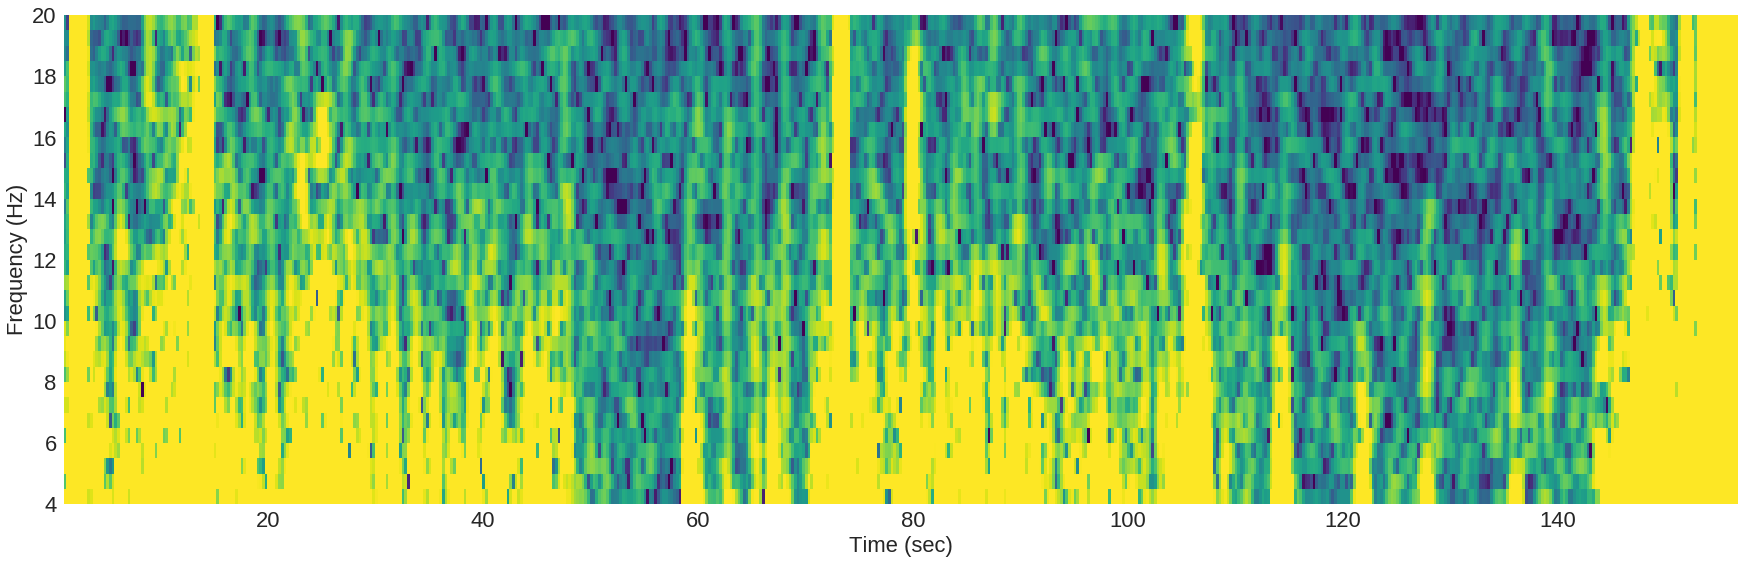

2
highpass filtering at: 1.0 Hz
notch filtering: 57.0-63.0 Hz
notch filtering: 117.0-123.0 Hz


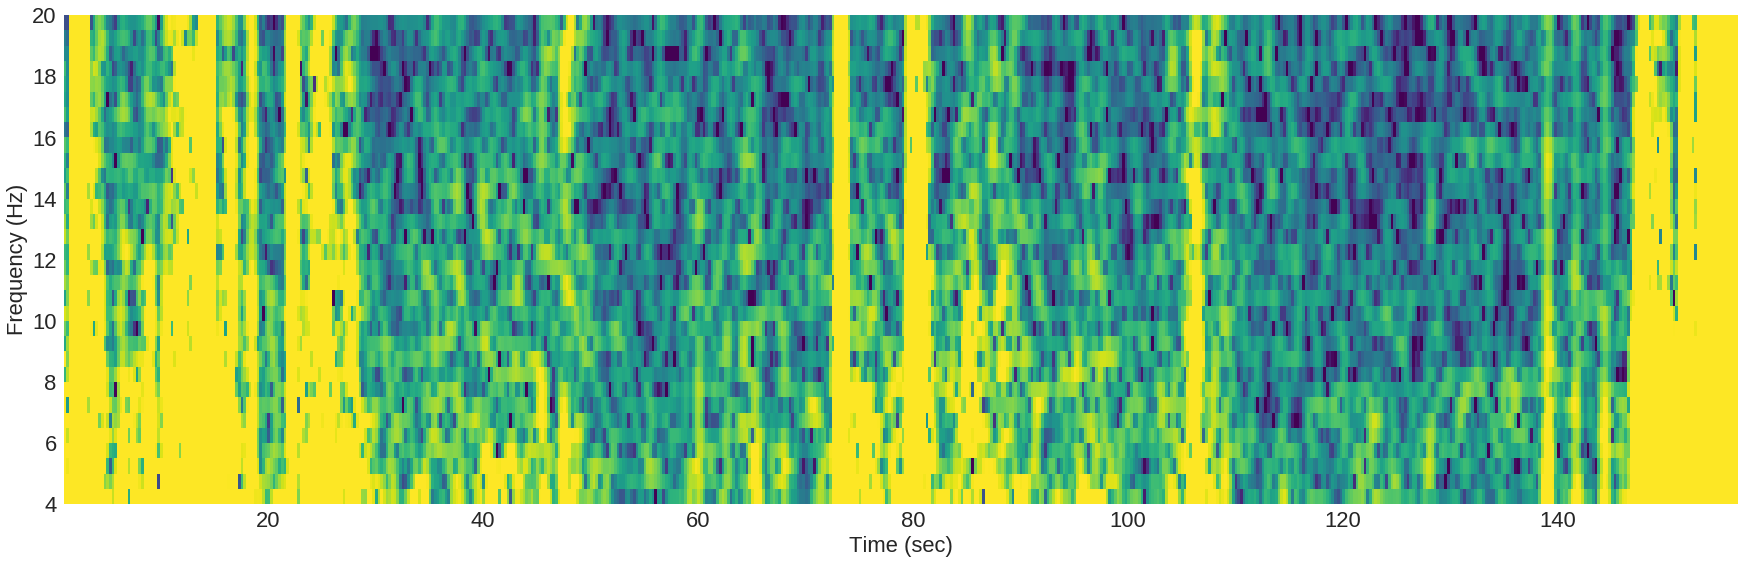

3
highpass filtering at: 1.0 Hz
notch filtering: 57.0-63.0 Hz
notch filtering: 117.0-123.0 Hz


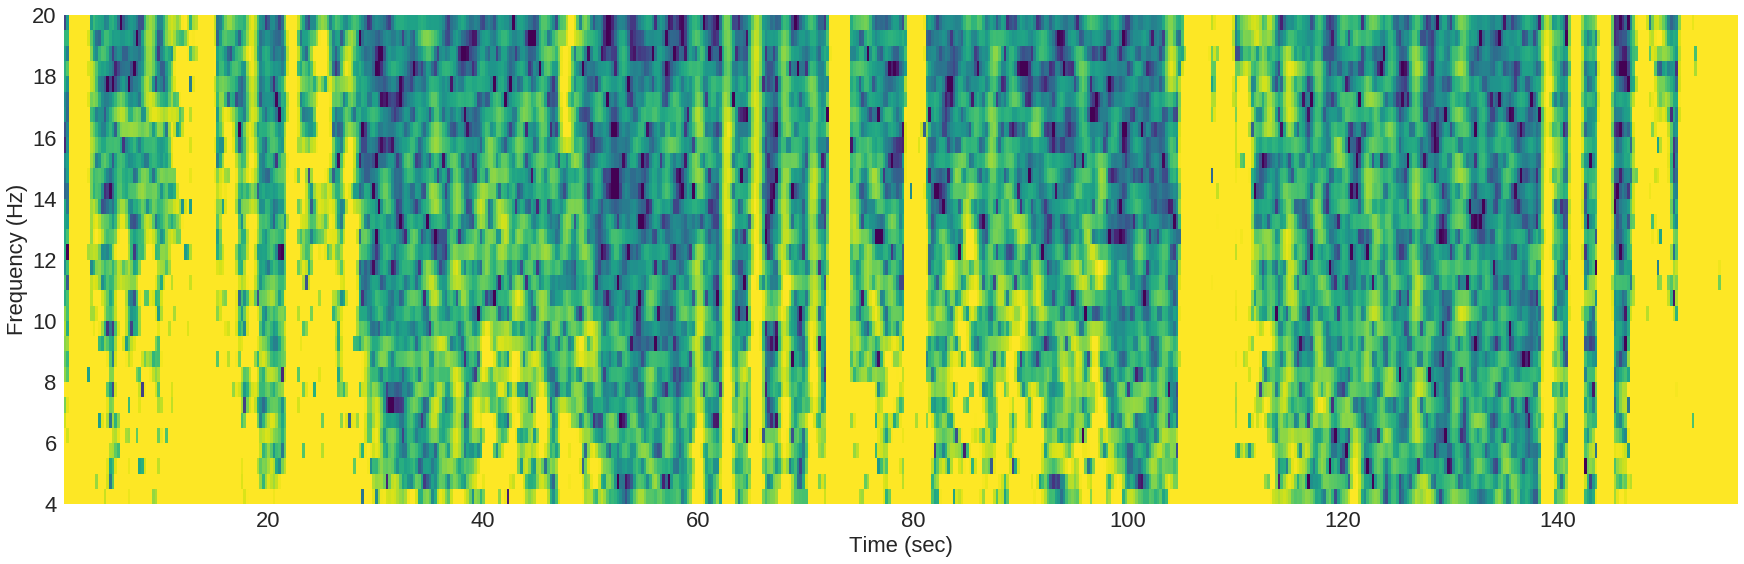

4
highpass filtering at: 1.0 Hz
notch filtering: 57.0-63.0 Hz
notch filtering: 117.0-123.0 Hz


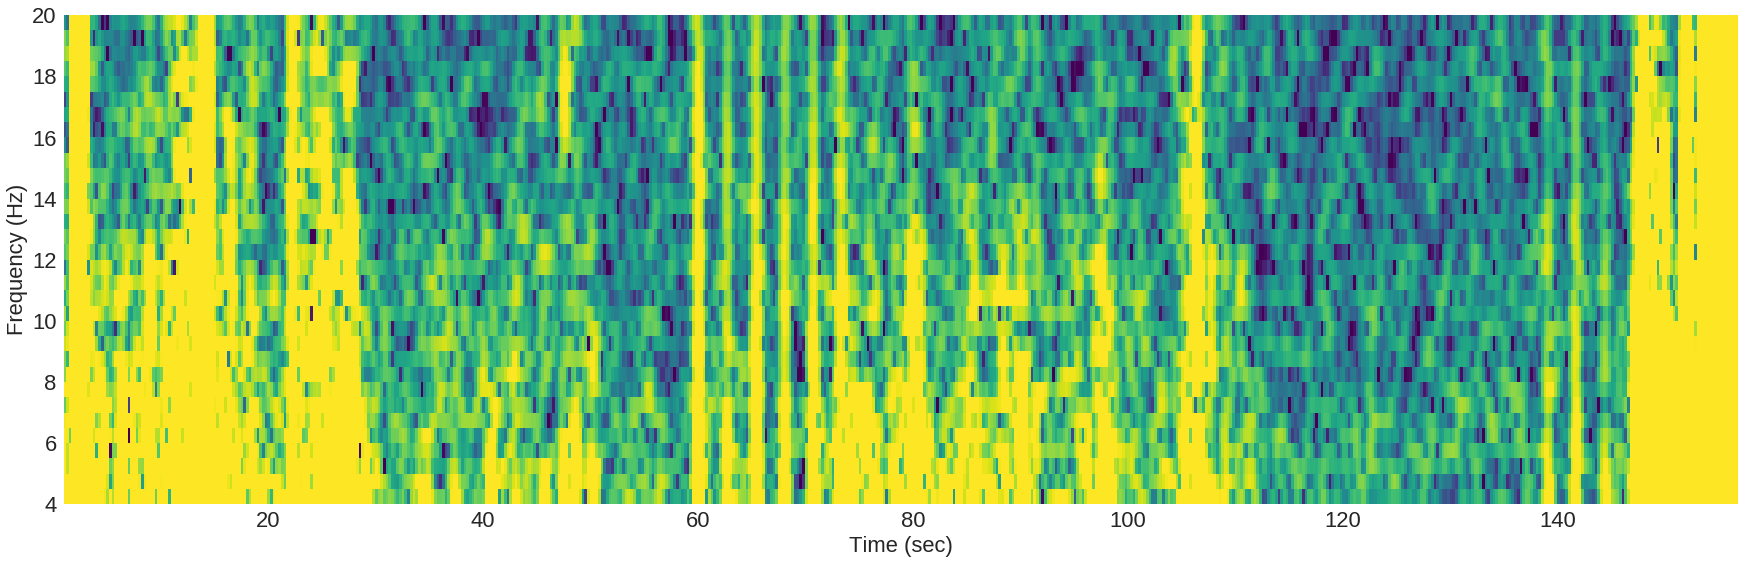

5
highpass filtering at: 1.0 Hz
notch filtering: 57.0-63.0 Hz
notch filtering: 117.0-123.0 Hz


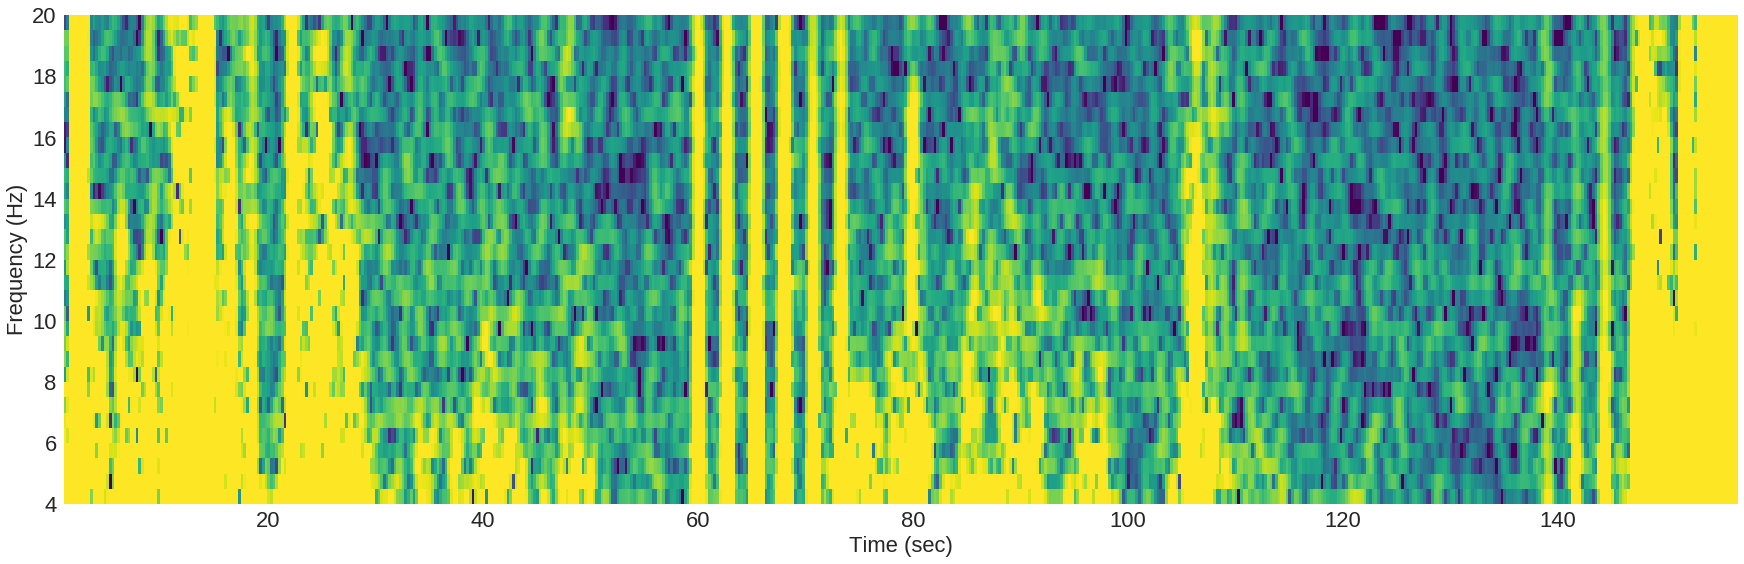

6
highpass filtering at: 1.0 Hz
notch filtering: 57.0-63.0 Hz
notch filtering: 117.0-123.0 Hz


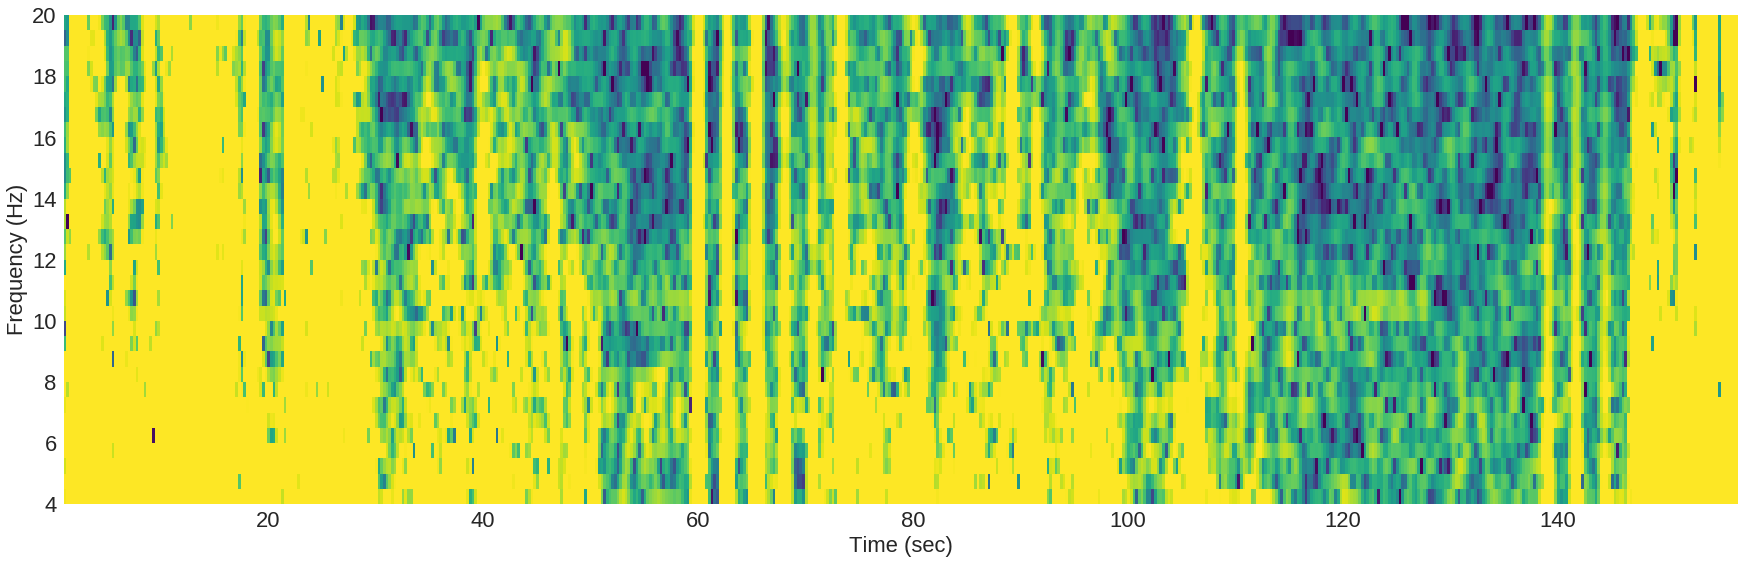

7
highpass filtering at: 1.0 Hz
notch filtering: 57.0-63.0 Hz
notch filtering: 117.0-123.0 Hz


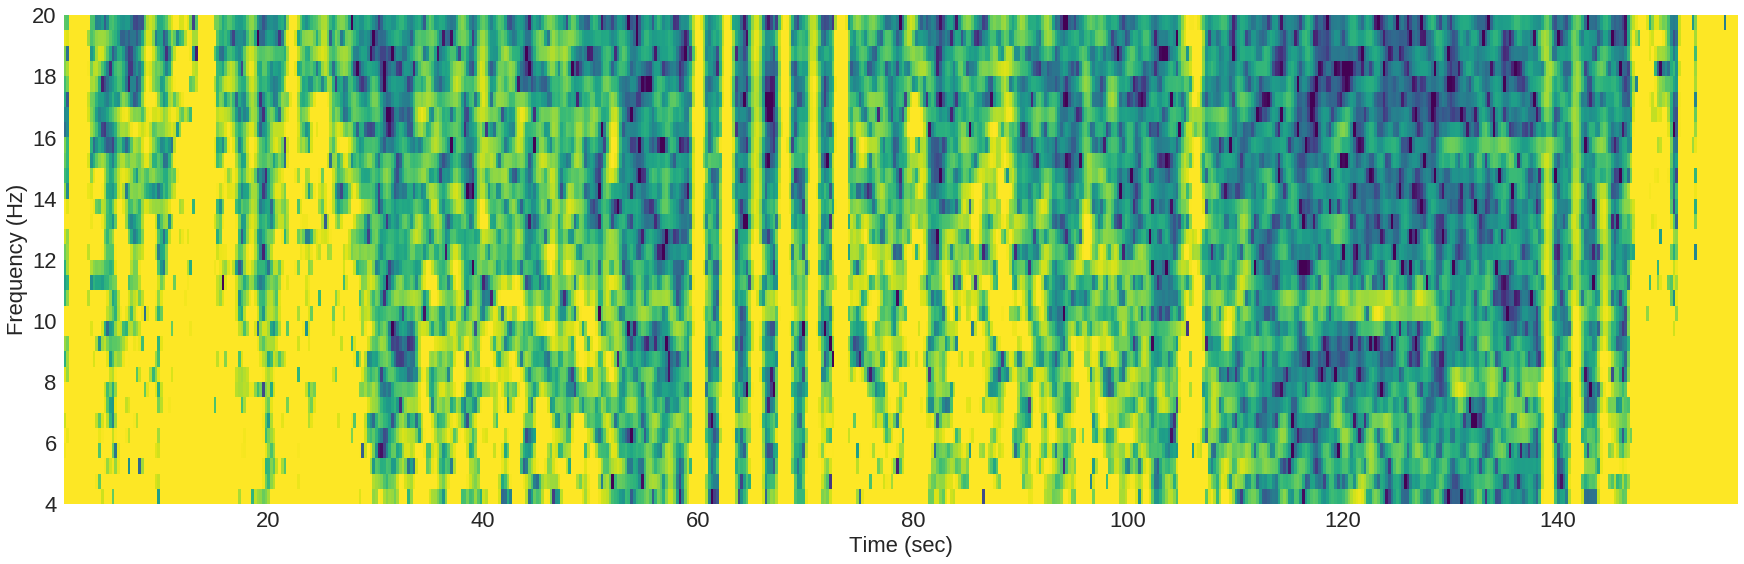

8
highpass filtering at: 1.0 Hz
notch filtering: 57.0-63.0 Hz
notch filtering: 117.0-123.0 Hz


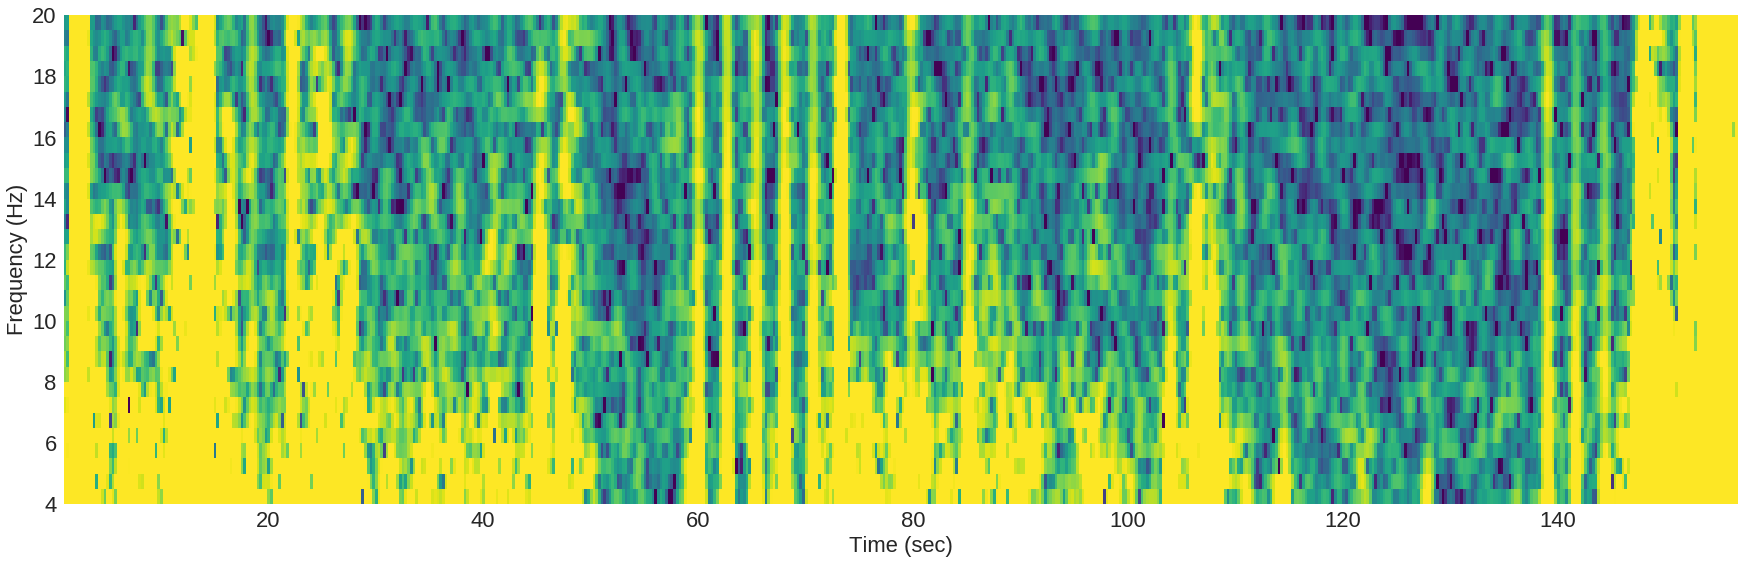

9
highpass filtering at: 1.0 Hz
notch filtering: 57.0-63.0 Hz
notch filtering: 117.0-123.0 Hz


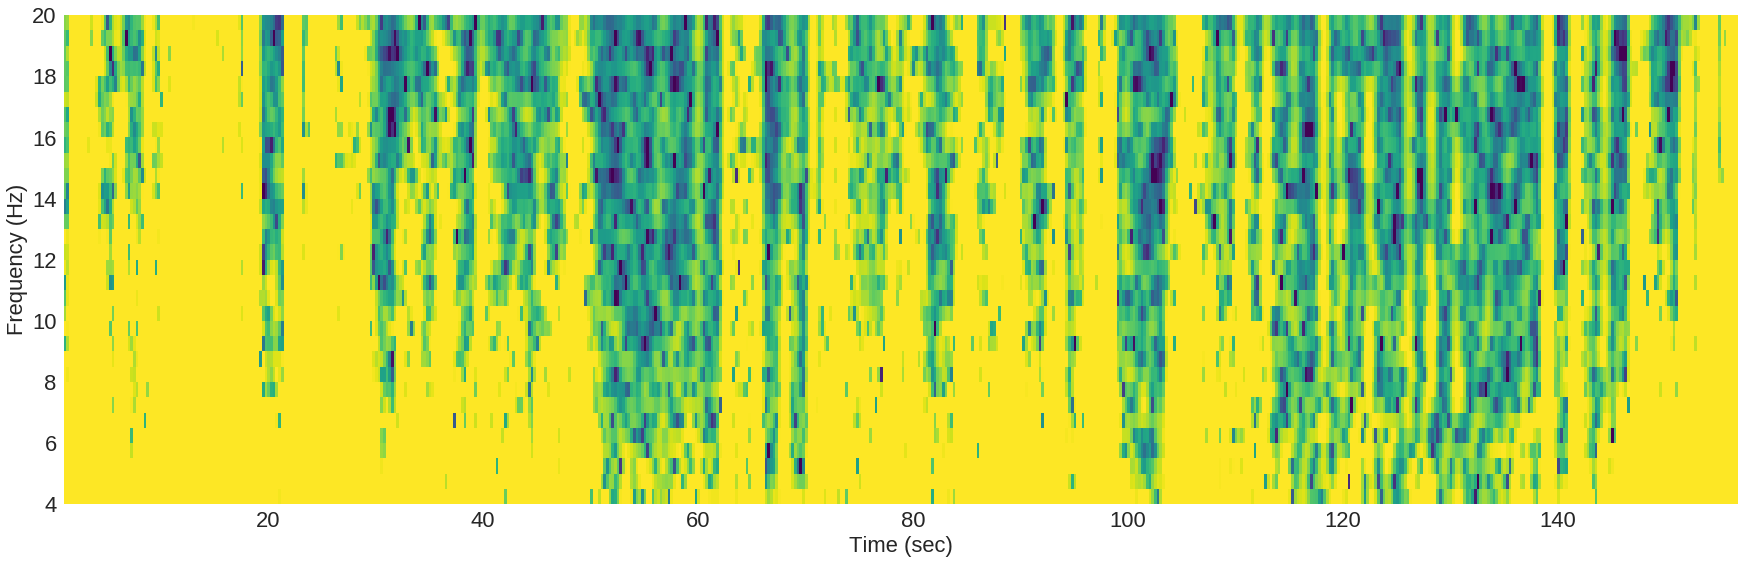

10
highpass filtering at: 1.0 Hz
notch filtering: 57.0-63.0 Hz
notch filtering: 117.0-123.0 Hz


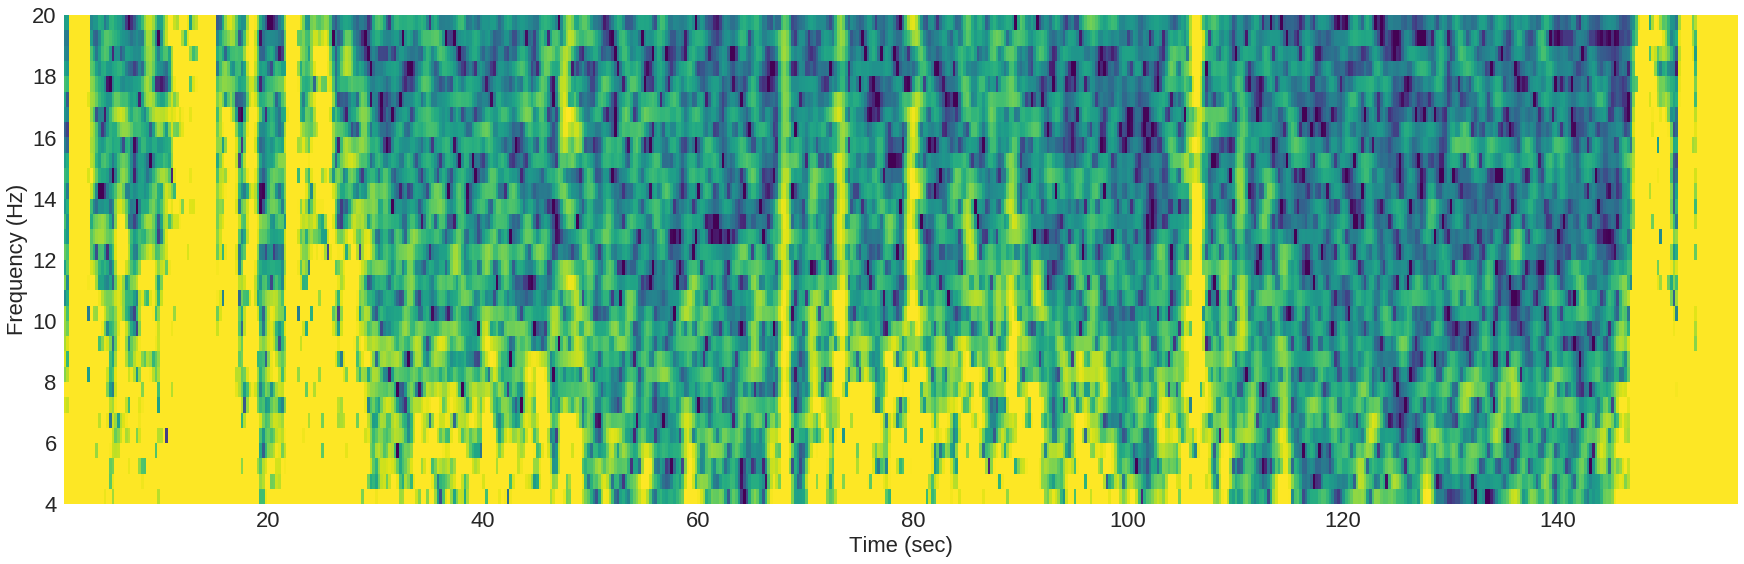

11
highpass filtering at: 1.0 Hz
notch filtering: 57.0-63.0 Hz
notch filtering: 117.0-123.0 Hz


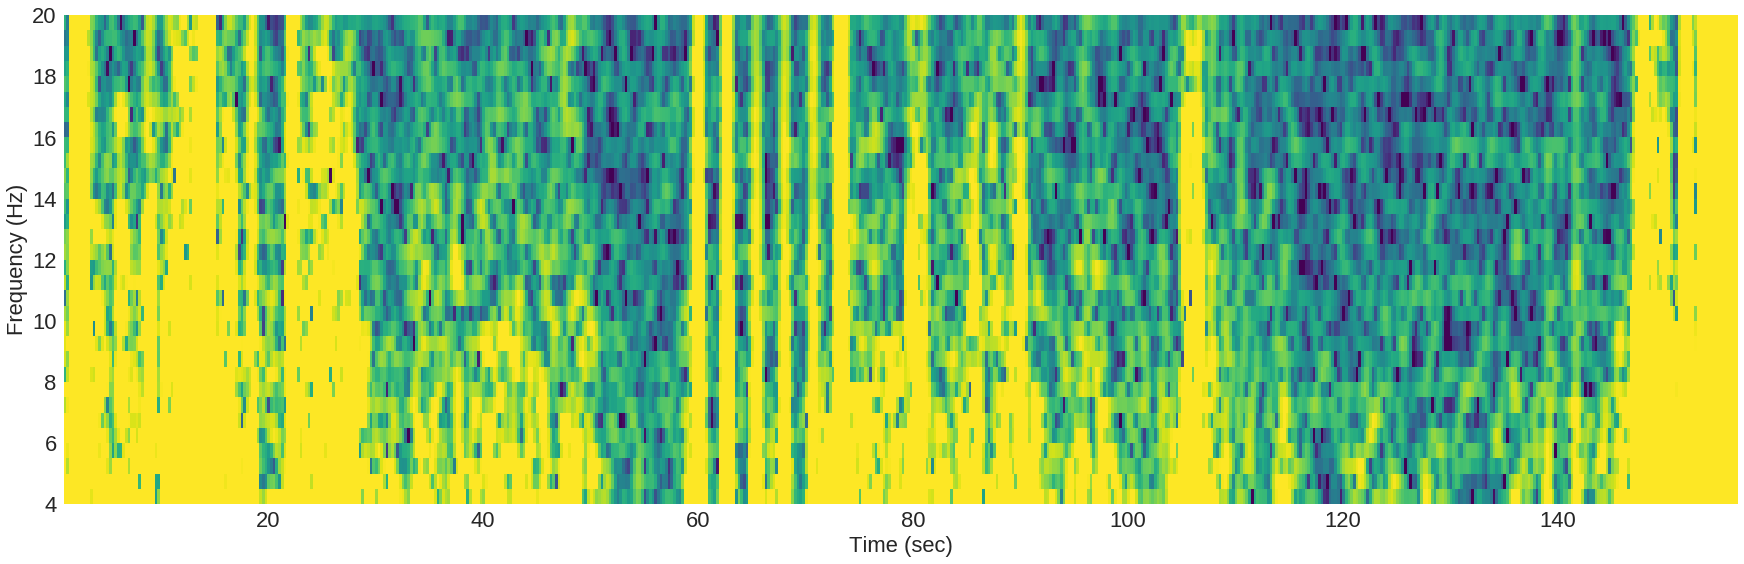

12
highpass filtering at: 1.0 Hz
notch filtering: 57.0-63.0 Hz
notch filtering: 117.0-123.0 Hz


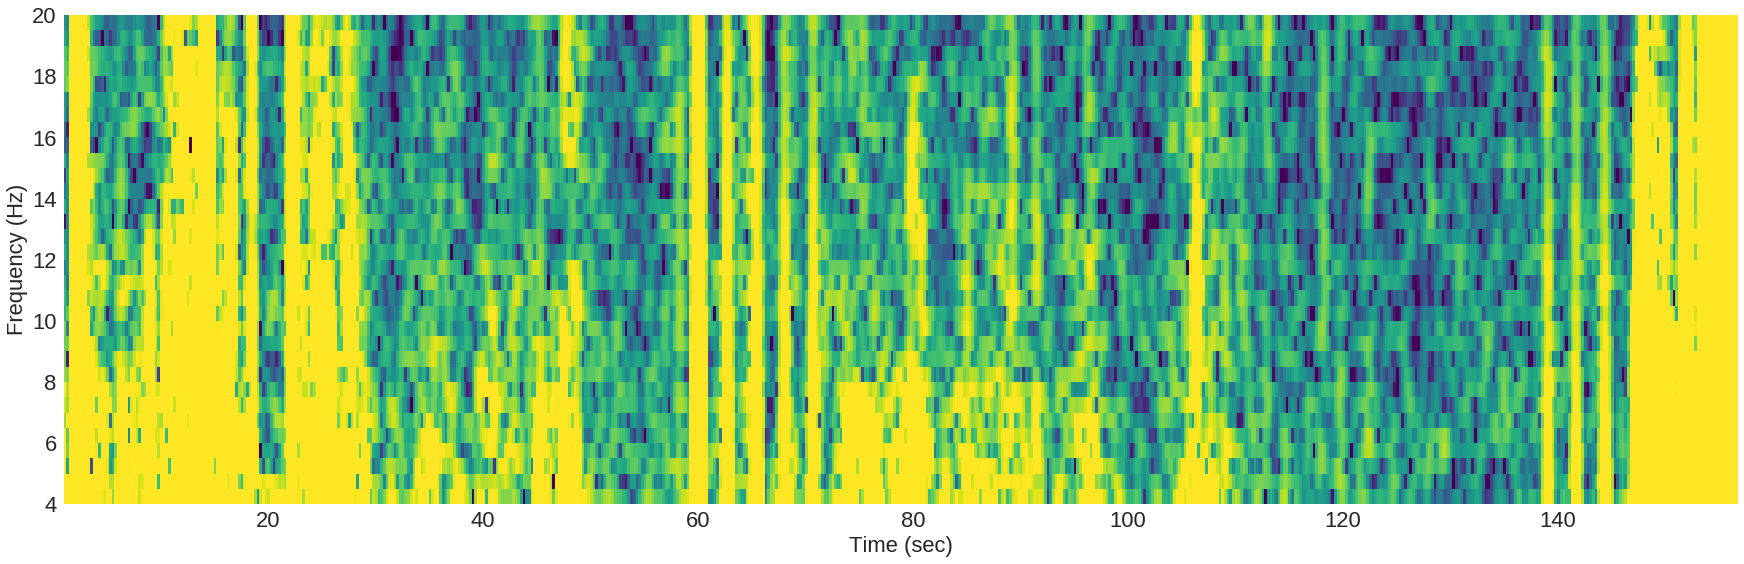

13
highpass filtering at: 1.0 Hz
notch filtering: 57.0-63.0 Hz
notch filtering: 117.0-123.0 Hz


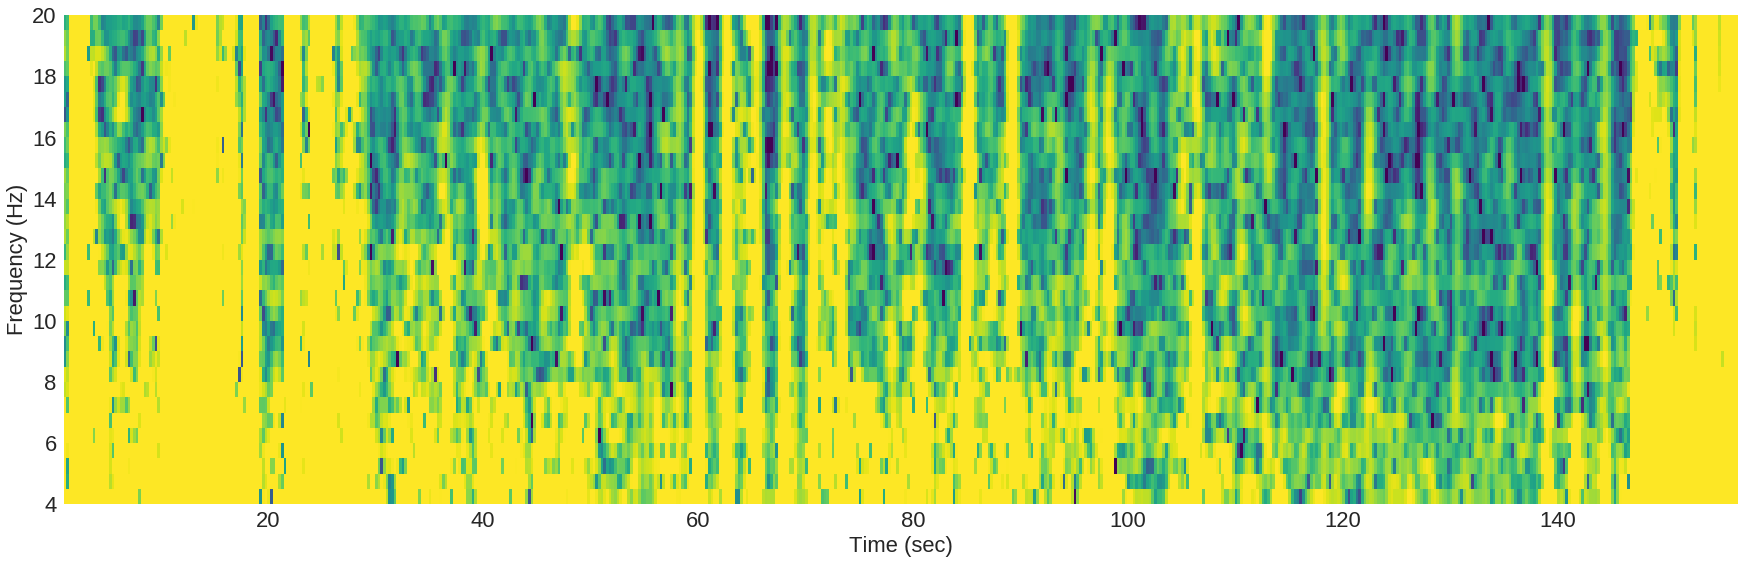

14
highpass filtering at: 1.0 Hz
notch filtering: 57.0-63.0 Hz
notch filtering: 117.0-123.0 Hz


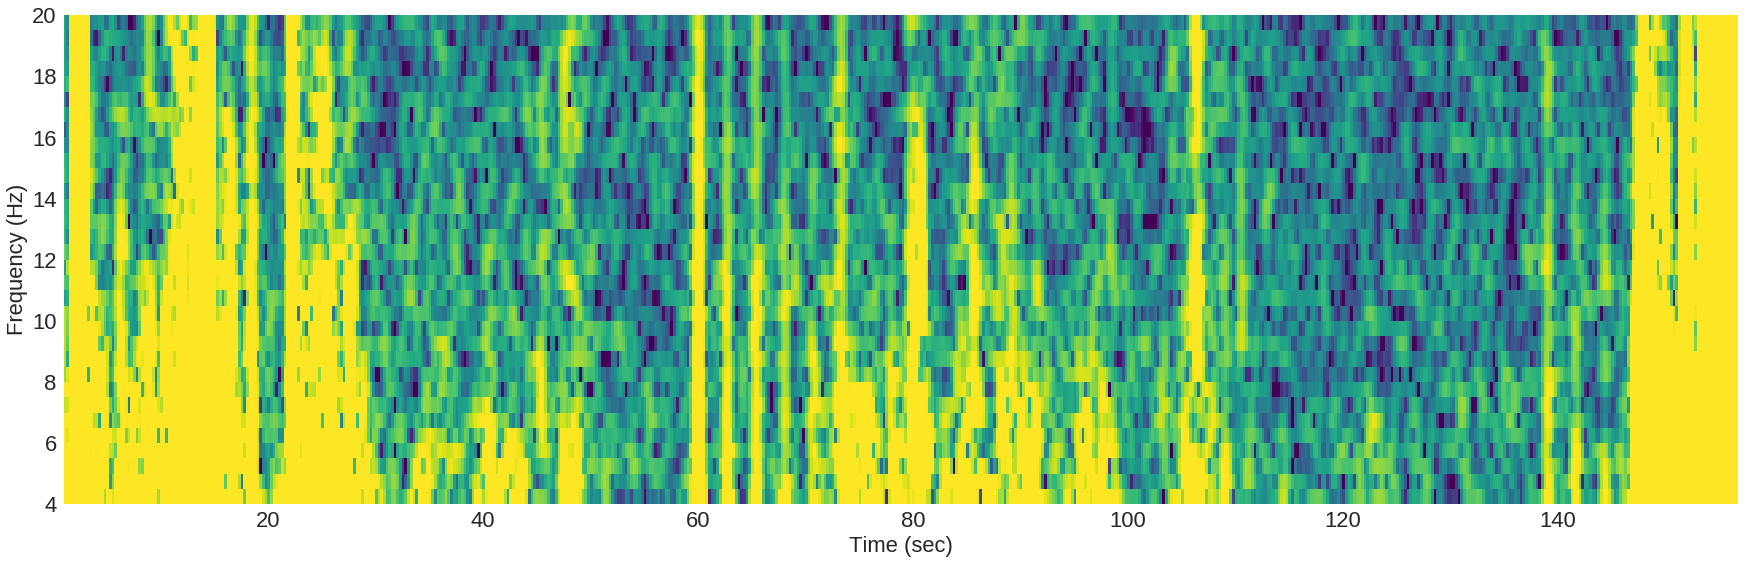

15
highpass filtering at: 1.0 Hz
notch filtering: 57.0-63.0 Hz
notch filtering: 117.0-123.0 Hz


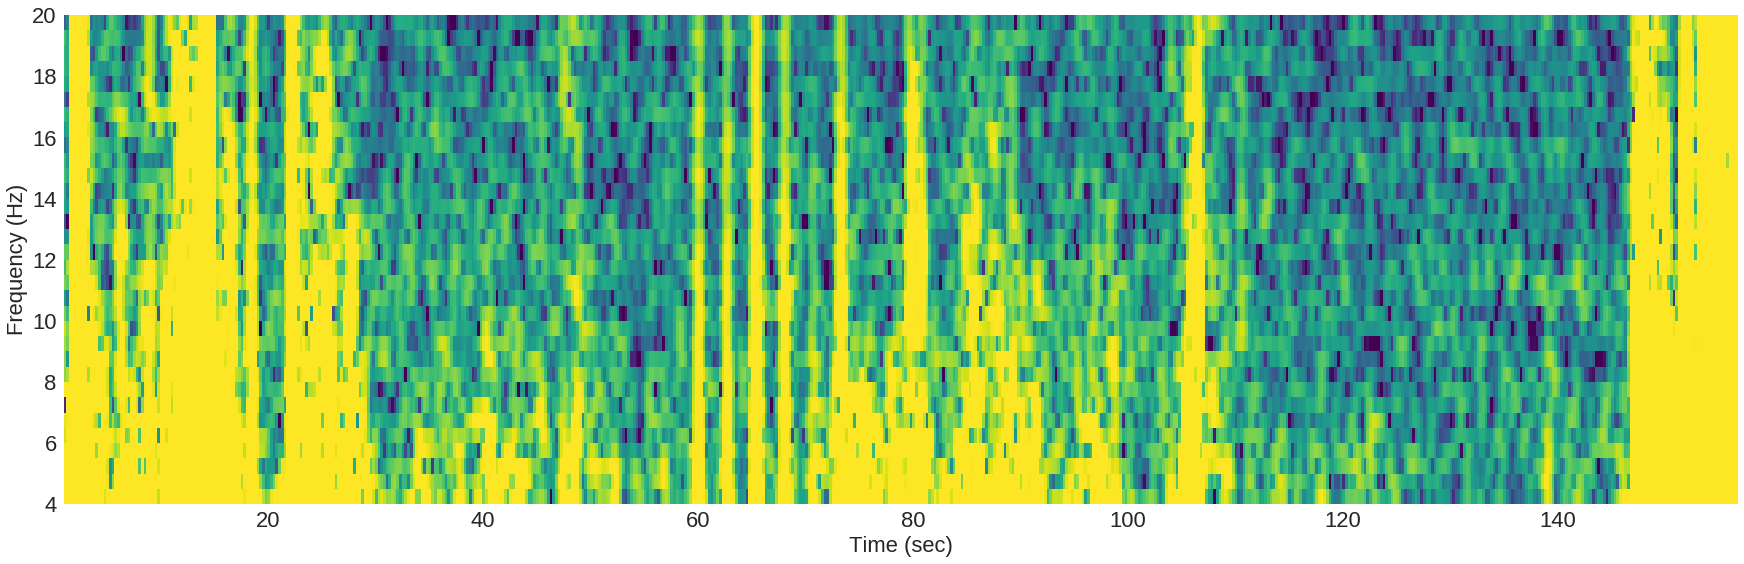

In [81]:
start=256*45
stop=256*100

for chan in range(1,16):    
    print(chan)
    raw_signal = bandpass_filter(data["adrian"]["data"],channel=chan)#[start:stop]
    spectrogram(raw_signal,min_freq=4,max_freq=20)

In [12]:
# https://matplotlib.org/examples/pylab_examples/specgram_demo.html
# Pxx is the segments x freqs array of instantaneous power, freqs is
# the frequency vector, bins are the centers of the time bins in which
# the power is computed, and im is the matplotlib.image.AxesImage
# instance

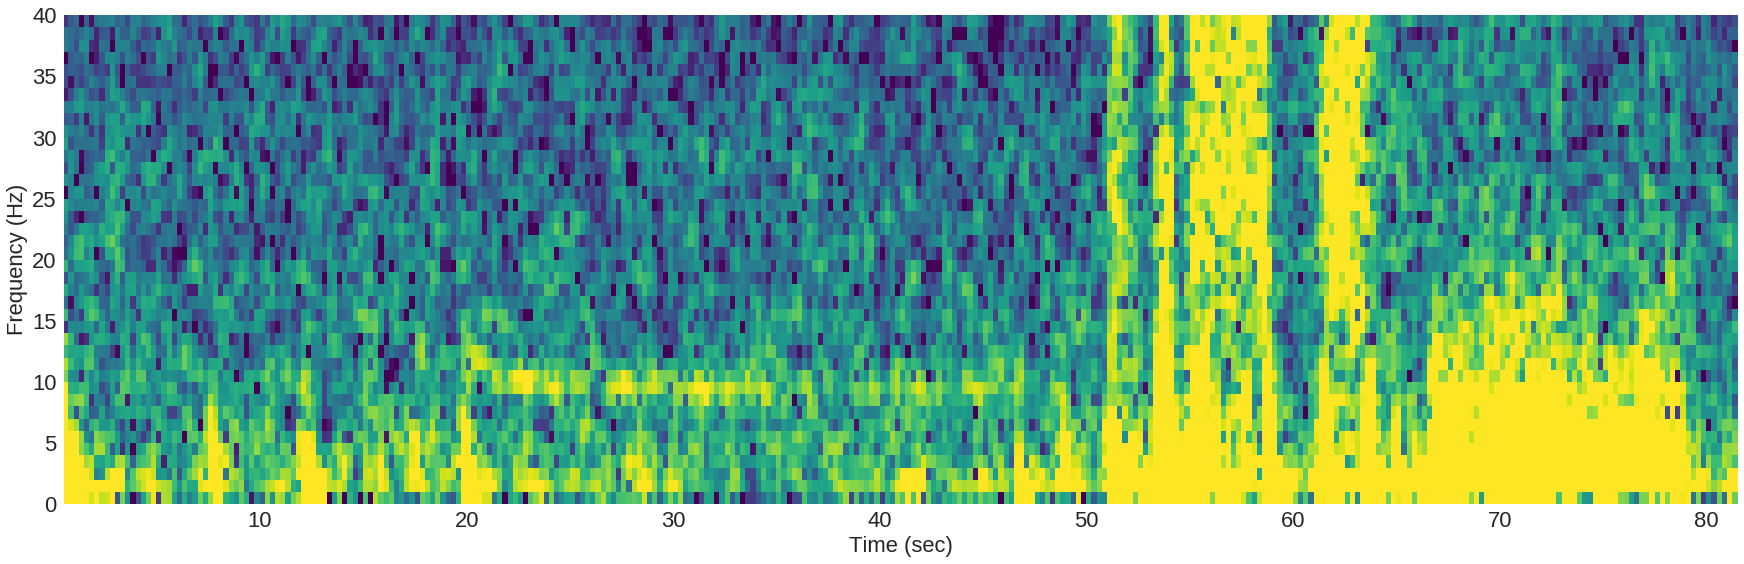

In [13]:
NFFT = int(sampling_rate*1) # length of the fft
overlap = NFFT - int(0.25 * sampling_rate)  # three quarter-second overlap

fig = plt.figure(figsize=(30, 9))

Pxx, freqs, bins, im = plt.specgram(clean_signal,NFFT=NFFT,\
                                    Fs=sampling_rate, noverlap=overlap, \
                                    cmap=plt.get_cmap('viridis'))

Pxx_perbin = Pxx * sampling_rate / float(NFFT)  #convert to "per bin"
# need to better understand that

# reduce size
# Pxx_perbin = Pxx_perbin[:, 1:-1:2]  # get every other time slice
# bins = bins[1:-1:2]  # get every other time slice

plt.pcolor(bins, freqs, 10*np.log10(Pxx_perbin), cmap=plt.get_cmap('viridis'))  # dB re: 1 uV
plt.clim(-15,15)
plt.xlim(bins[0], bins[-1])
plt.ylim(0,40)
plt.xlabel('Time (sec)',fontsize=22)
plt.ylabel('Frequency (Hz)',fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.show()

### Kmeans attempt 1

In [14]:
scaler = preprocessing.StandardScaler()

In [15]:
training_data = scaler.fit_transform(df[data_cols])

In [16]:
cluster = KMeans(n_clusters=4)

In [17]:
results = cluster.fit_predict(training_data)

In [18]:
df['cluster_number'] = results

82 seconds of recording


(array([-0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5]),
 <a list of 9 Text yticklabel objects>)

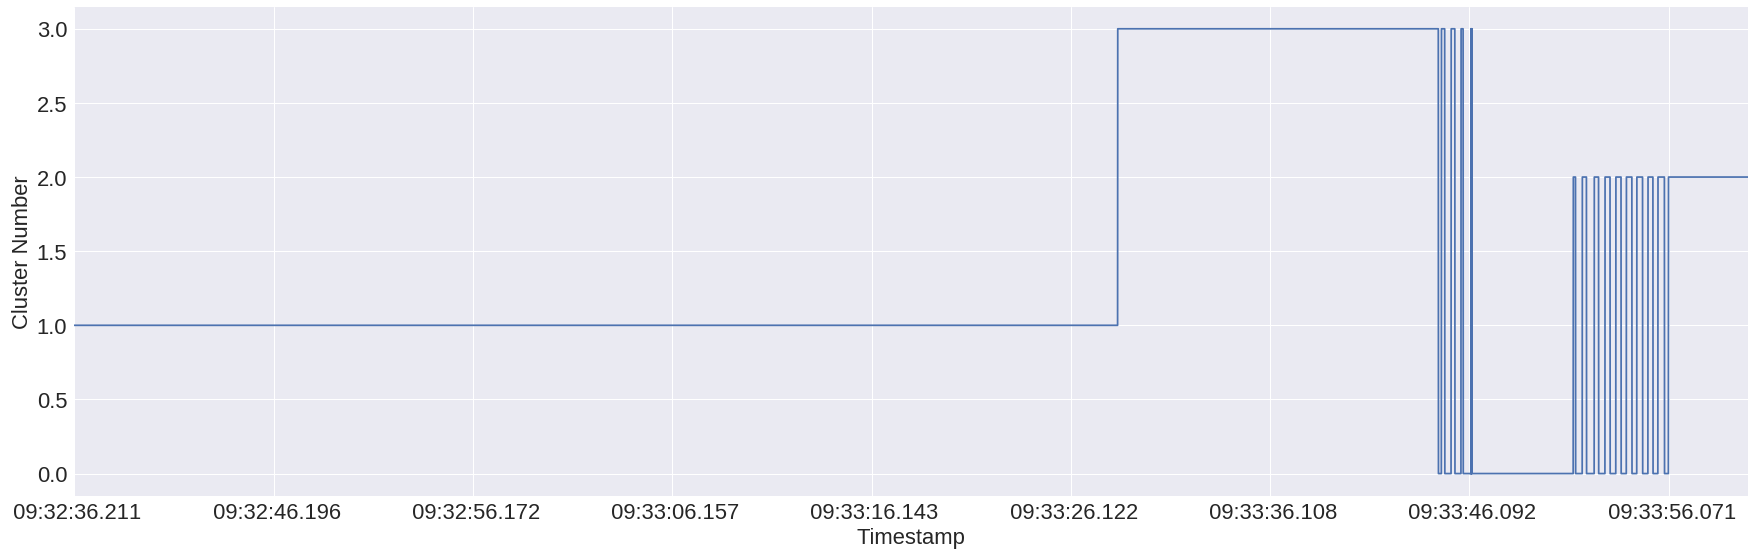

In [19]:
start_index = 0
duration=int(len(df.iloc[start_index:])/sampling_rate)
print("{} seconds of recording".format(duration))
df.iloc[start_index:]["cluster_number"].plot(figsize=(30,9))
plt.xlabel('Timestamp',fontsize=22)
plt.ylabel('Cluster Number',fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

#### KMeans is probably heavily relying on signal magnitude to drive cluster assignment
- one neat observation here is that this first does a pretty good job breaking up the jaw clenching vs headshaking sections
- it also appears to be making cluster assignments according to the back and forth movement of my head at the end of the recording!
- now let's move from the time domain to the frequency domain and summarize the frequency with the maximum magnitude, the mean frequency, the sum of the magnitude, and the power of the signal (i.e. mag**2)

### Try creating generating a frequency summary for each timestep (timestep adjustable) for 1 channel of EEG Data (Channel 8/O2)
- NB: I'm going to start with one channel for two reasons: 1) ease of initial analysis, and 2) if we create 4 features for each of the 16 channels, then we'll have 64 features per timestep, which means we'll need to start thinking about PCA due to the curse of dimensionality

In [20]:
n = len(clean_signal) # length of the signal
k = np.arange(n) # array of timesteps in observations
T = n/float(sampling_rate) # number of sampling cycles 
freqs = k/np.float(T) # two sides frequency range 
freqs = freqs[range(n/2)] # one side frequency range # due to nyquist frequency

lower_freq = 0.
upper_freq = 40.
mask = np.logical_and(freqs >= lower_freq, freqs <= upper_freq)

Y = np.fft.fft(clean_signal)*2/n # fft computing and normalization # why normalize? again a result of the nyquist frequency
Y = Y[range(n/2)] # only taking half of the outputs
Y = np.abs(Y) # take the magnitude of the signals

# filter down to frequencies of interest
Y = Y[mask]
freqs = freqs[mask]

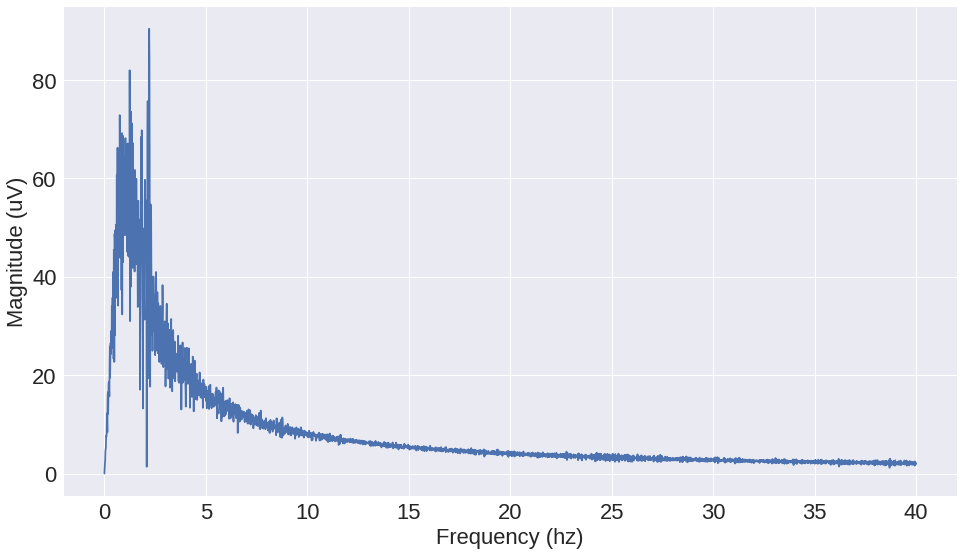

In [21]:
fig = plt.figure(figsize=(16, 9))
plt.plot(freqs, Y)
plt.xlabel("Frequency (hz)",fontsize=22)
plt.ylabel("Magnitude (uV)",fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.show()

In [22]:
def fft(data, sampling_rate=256, lower_freq=0., upper_freq=40.):
    n = len(data) # length of the signal
    k = np.arange(n) # array of timesteps in observations
    T = n/float(sampling_rate) # number of sampling cycles 
    freqs = k/np.float(T) # two sides frequency range 
    freqs = freqs[range(n/2)] # one side frequency range # due to nyquist frequency

    mask = np.logical_and(freqs >= lower_freq, freqs <= upper_freq)

    Y = np.fft.fft(data)*2/n # fft computing and normalization # why normalize? again a result of the nyquist frequency
    Y = Y[range(n/2)] # only taking half of the outputs
    Y = np.abs(Y) # take the magnitude of the signals

    # filter down to frequencies of interest
    Y = Y[mask]
    freqs = freqs[mask]
    
    return Y, freqs

In [23]:
def descriptive_stats(freq_data, mag_data):
    max_mag_freq = freq_data[mag_data.argmax()]
    mean_freq = np.sum((freq_data * (mag_data/np.sum(mag_data))))
    mag = np.sum(mag_data)
    power = np.sum(mag_data**2)
    return [max_mag_freq, mean_freq, mag, power]

In [24]:
# generate summary statistics
plotting = False
output = []
step_size_seconds = 1.
step_size = step_size_seconds*sampling_rate
for i in range(0,len(clean_signal),int(step_size)):
    Y, freqs = fft(clean_signal[i:i+int(step_size)],lower_freq=1.)
    descr = descriptive_stats(mag_data=Y, freq_data=freqs)
    output.append(descr)
    
    if plotting:
        fig, ax = plt.subplots()
        ax.plot(freqs, Y)
        plt.xlabel("Frequency (hz)")
        plt.ylabel("Magnitude (uV)")
        plt.show()

In [25]:
# first and last readings are a little haywire
output = output[1:-1]

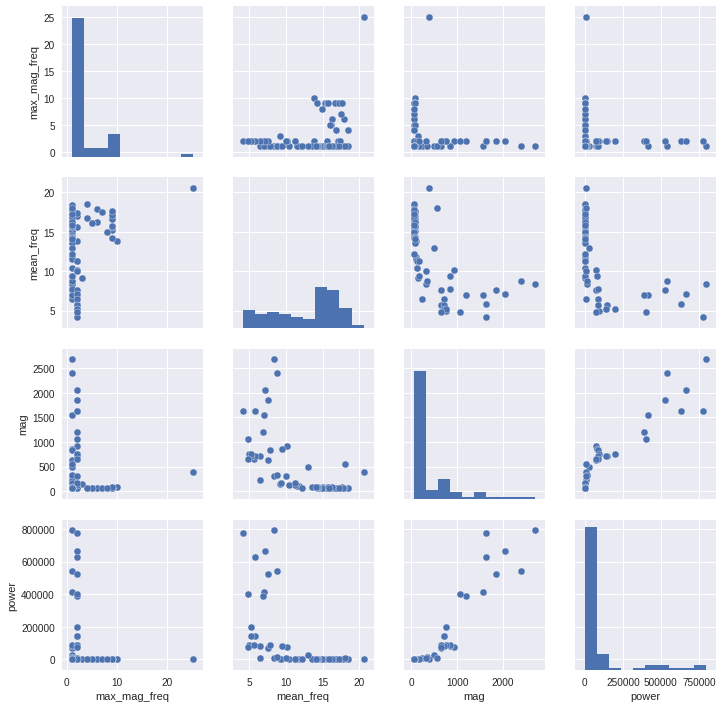

In [26]:
# pairplots are good for giving you a visual sense of data distributions and if
# there are any obvious clusters
sns.pairplot(pd.DataFrame(output, columns=["max_mag_freq", "mean_freq", "mag", "power"]))

### Use max magnitude frequency for KMeans

In [27]:
# output contains [max magnitude frequency, mean frequency, 
# sum of magnitude, power (i.e. mag**2)]
features = [0]
data = np.array(output)[:,features]

In [28]:
training_data = scaler.fit_transform(data)

In [29]:
cluster = KMeans(n_clusters=4)

In [30]:
results = cluster.fit_predict(data)

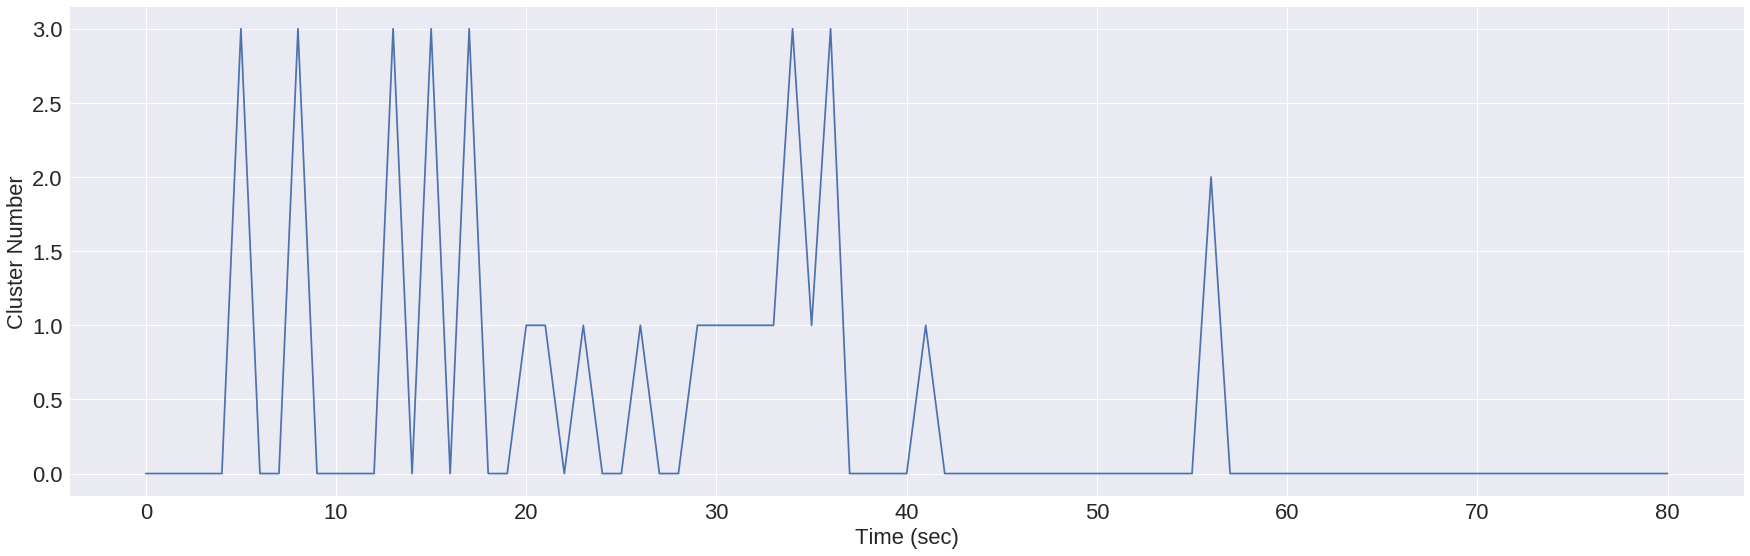

In [31]:
fig, ax = plt.subplots(figsize=(30,9))
ax.plot(range(0,len(results)), results)
plt.xlabel('Time (sec)',fontsize=22)
plt.ylabel('Cluster Number',fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.show()

#### It appears that this feature isn't perfect for clustering everything but it DOES start to carve out the eyes closed portions.
- I'm sure my alpha signal wasn't perfectly steady so I'm not surprised there are multiple cluster assignments between second 20-40
- This feature can't really tell the difference between jaw clenching and head shaking, so we can look at finding that feature next

### Use magnitude sum within the window for KMeans

In [32]:
# output contains [max magnitude frequency, mean frequency, 
# sum of magnitude, power (i.e. mag**2)]
features = [2]
data = np.array(output)[:,features]

In [33]:
training_data = scaler.fit_transform(data)

In [34]:
cluster = KMeans(n_clusters=4)

In [35]:
results = cluster.fit_predict(data)

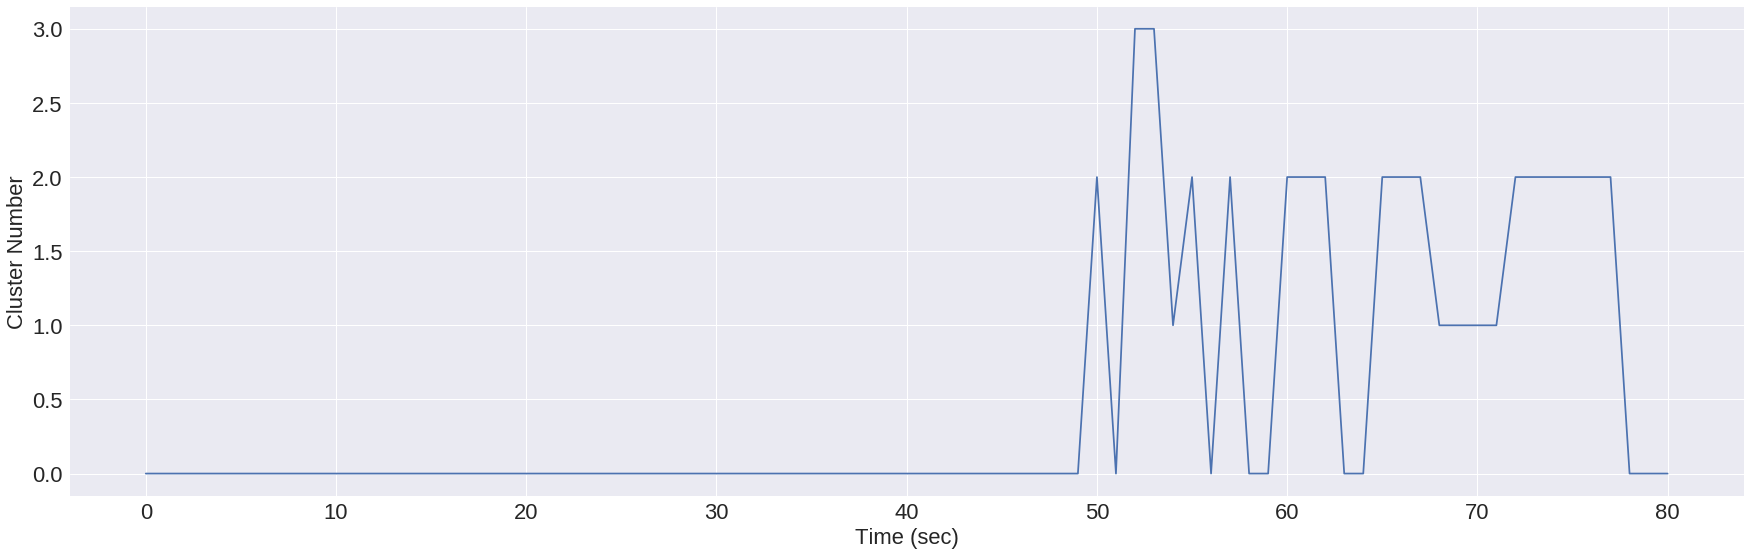

In [36]:
fig, ax = plt.subplots(figsize=(30,9))
ax.plot(range(0,len(results)), results)
plt.xlabel('Time (sec)',fontsize=22)
plt.ylabel('Cluster Number',fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.show()

#### It appears that this feature isn't perfect for clustering everything either but it DOES start to break up the jaw clenching and head shaking.
- We're probably seeing the faults of the KMeans algorithm here..
- Since the variance of the magnitude feature within the jaw clenching and head shaking portion of the segment is so high, it works on minimizing variance within those clusters, while the lower variance normal and eyes closed segment looks like 1 blob that doesn't need to be broken up

### Here we learned a couple things:
- What features can be created to summarize the EEG signals
- What those features might be good for